<a href="https://colab.research.google.com/github/Vishnupriya-Selvraj/demand-forecasting-and-price-elasticity/blob/main/FMCG_Sales_Forecasting_ML_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
beatafaron_fmcg_daily_sales_data_to_2022_2024_path = kagglehub.dataset_download('beatafaron/fmcg-daily-sales-data-to-2022-2024')

print('Data source import complete.')


Using Colab cache for faster access to the 'fmcg-daily-sales-data-to-2022-2024' dataset.
Data source import complete.


# Forecasting Daily Sales of FMCG Products

This notebook presents a full machine learning pipeline for **forecasting daily units sold** of fast-moving consumer goods (FMCG) based on 2022–2024 sales data.

We approach this as a **regression task** per product category and aim to model **fine-grained daily dynamics** across SKUs, prices, promotions, and stock levels.

### Goal
Build a robust model that:
- Predicts **daily sales** (`units_sold`) per SKU
- Handles seasonality, stockouts, price/promo effects
- Generalizes well across time and categories

### Dataset
The dataset contains:
- ~190k daily records (2022–2024)
- SKUs with product metadata (`brand`, `segment`, `category`)
- Daily signals like `price_unit`, `promotion_flag`, `stock_available`, and `delivery_days`
- Target variable: `units_sold` (how many units sold per SKU per day)

### Approach
- **Feature Engineering**: lags, rolling stats, trends, calendar features, interaction terms
- **Per-Category Modeling**: separate LightGBM model per `category`
- **Custom Feature Selection**: selecting top-K features via importance
- **Evaluation**: metrics like RMSE, MAPE, SMAPE, R2, both per-category and per-SKU

> This setup simulates a **real-world demand forecasting use case** in retail or supply chain planning. It can be used to optimize inventory, logistics, and promotions.

---



In [ ]:
# === Libraries ===
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import clone
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Exploratory Data Analys
###  Dataset Overview
- Shape: 190,757 rows × 14 columns
- Time range: 2022-01-01 → 2024-12-31
- Target: units_sold (int) — daily sales per SKU
- No missing values
- No duplicated rows
### Notes:
- Negative values in stock_available, delivered_qty, and units_sold — need validation.

In [ ]:
df = pd.read_csv("/content/hm_enhanced_2023_2024_live.csv", parse_dates=["Date"])
df_eda = df.copy()

In [ ]:
print("Shape:", df_eda.shape)

Shape: (350880, 29)


In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350880 entries, 0 to 350879
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    350880 non-null  datetime64[ns]
 1   StoreID                 350880 non-null  int64         
 2   City                    350880 non-null  object        
 3   Region                  350880 non-null  object        
 4   MallName                350880 non-null  object        
 5   Category                350880 non-null  object        
 6   Subcategory             350880 non-null  object        
 7   SKU                     350880 non-null  object        
 8   Brand                   350880 non-null  object        
 9   Price                   350880 non-null  float64       
 10  DiscountPct             350880 non-null  float64       
 11  PromoFlag               350880 non-null  int64         
 12  QuantitySold            350880

## Feature Summary
- sku: 30 unique SKUs — most frequent is MI-006 (8,221 records)
- brand: 14 brands — top is SnBrand2
- segment: 13 segments — top is Yogurt-Seg1
- category: 5 categories — most popular is Yogurt
- channel: 3 channels — Retail dominates (63K+ rows)
- region: 3 total, top is PL-North


In [ ]:
df_eda.describe(include="all")

,Date,StoreID,City,Region,MallName,Category,Subcategory,SKU,Brand,Price,...,IsHoliday,HolidayEvent,CPI,UnemploymentRate,ConsumerIncome,MarketingSpend_Online,MarketingSpend_Offline,ChannelOnline,StoreTier,StoreSize
count,350880,350880.00000,350880,350880,350880,350880,350880,350880,350880,350880.000000,...,350880.000000,49440,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000,350880.000000,350880,350880.000000
unique,NaN,NaN,17,5,16,8,22,24,1,NaN,...,NaN,52,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,Mumbai,South,Phoenix MarketCity,T-Shirt,Basic,HM-TS-001,H&M,NaN,...,NaN,Makar Sankranti,NaN,NaN,NaN,NaN,NaN,NaN,Tier 1,NaN
freq,NaN,NaN,35088,140352,70176,43860,29240,14620,350880,NaN,...,NaN,1920,NaN,NaN,NaN,NaN,NaN,NaN,175440,NaN
mean,2024-01-01 00:00:00.000000256,10.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1762.471233,...,0.140903,NaN,199.391122,4.012927,55007.123838,645.304602,470.199244,0.401499,NaN,8150.000000
min,2023-01-01 00:00:00,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.200000,...,0.000000,NaN,180.200000,3.500000,32000.010000,210.170000,140.110000,0.000000,NaN,4500.000000
25%,2023-07-02 00:00:00,5.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1127.880000,...,0.000000,NaN,188.320000,3.760000,44447.017500,451.520000,319.160000,0.000000,NaN,6375.000000
50%,2024-01-01 00:00:00,10.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1633.700000,...,0.000000,NaN,199.220000,4.020000,55154.990000,602.660000,432.590000,0.000000,NaN,8250.000000
75%,2024-07-02 00:00:00,15.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2227.232500,...,0.000000,NaN,209.990000,4.260000,65001.415000,822.392500,601.207500,1.000000,NaN,10000.000000
max,2024-12-31 00:00:00,20.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5297.840000,...,1.000000,NaN,219.920000,4.500000,77999.890000,1199.980000,899.820000,1.000000,NaN,12000.000000


In [ ]:
print("Duplicated rows:", df_eda.duplicated().sum())

Duplicated rows: 0


In [ ]:
df_eda.isna().sum()

,0
Date,0
StoreID,0
City,0
Region,0
MallName,0
Category,0
Subcategory,0
SKU,0
Brand,0
Price,0


In [ ]:
df_eda.nunique()

,0
Date,731
StoreID,20
City,17
Region,5
MallName,16
Category,8
Subcategory,22
SKU,24
Brand,1
Price,206652


In [ ]:
# Date range
print("Min date:", df_eda["Date"].min())
print("Max date:", df_eda["Date"].max())

Min date: 2023-01-01 00:00:00
Max date: 2024-12-31 00:00:00


<Axes: title={'center': 'Entries per Day'}, xlabel='Date'>

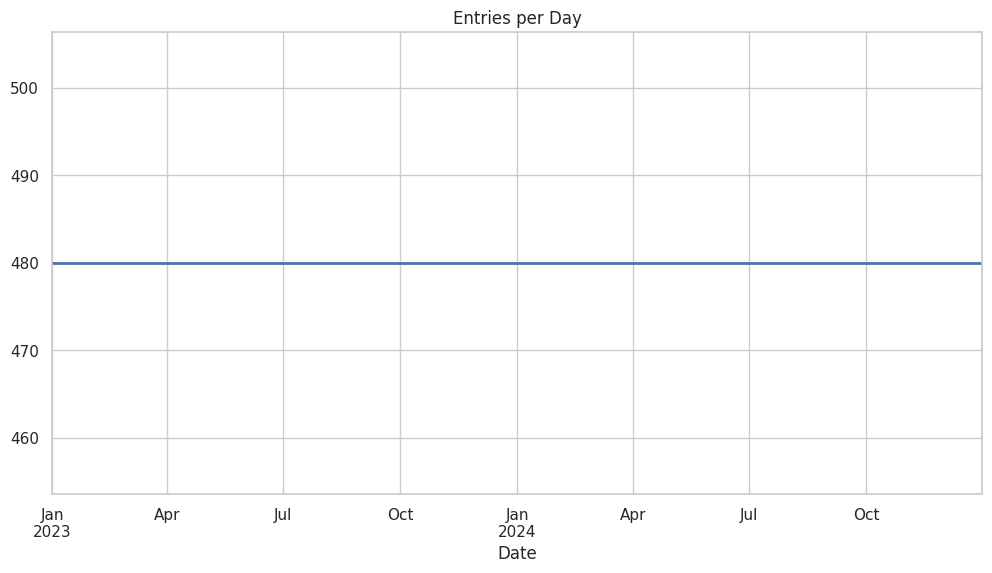

In [ ]:
# Entries per date
df_eda["Date"].value_counts().sort_index().plot(title="Entries per Day", lw=2)

<Axes: title={'center': 'Total Units Sold over Time'}, xlabel='Date'>

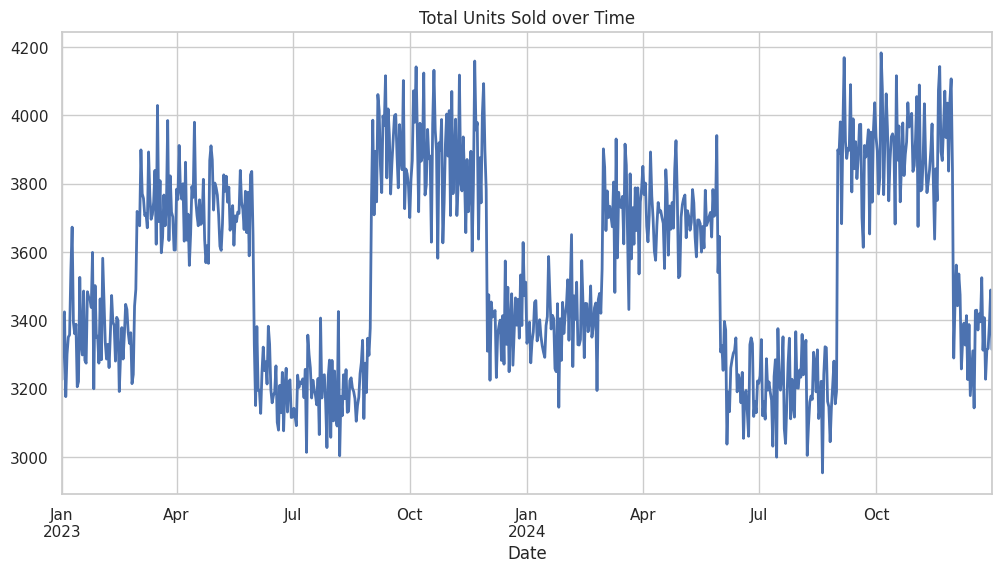

In [ ]:
# Total sales over time
df_eda.groupby("Date")["QuantitySold"].sum().plot(title="Total Units Sold over Time", lw=2)

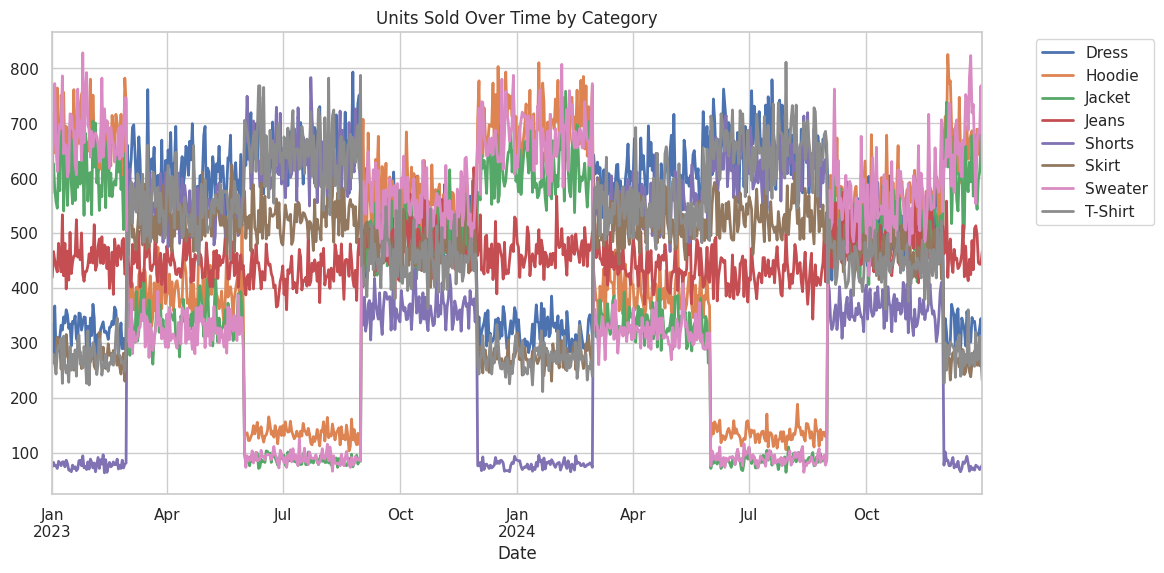

In [ ]:
# Time trends by category
df_cat_trend = df_eda.groupby(["Date", "Category"])["QuantitySold"].sum().unstack()
df_cat_trend.plot(title="Units Sold Over Time by Category", lw=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

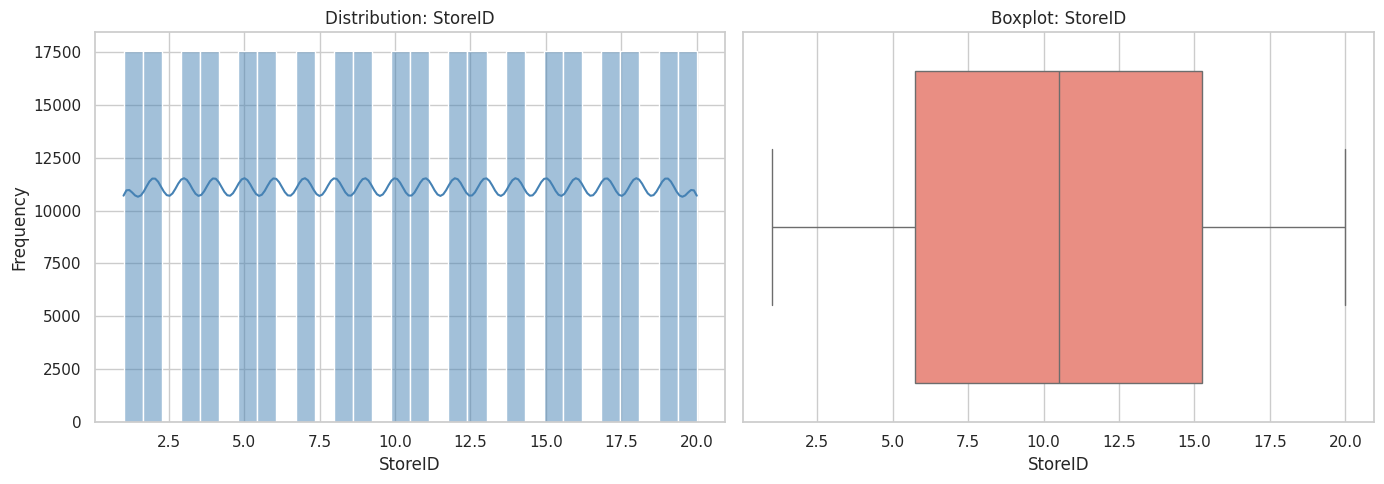

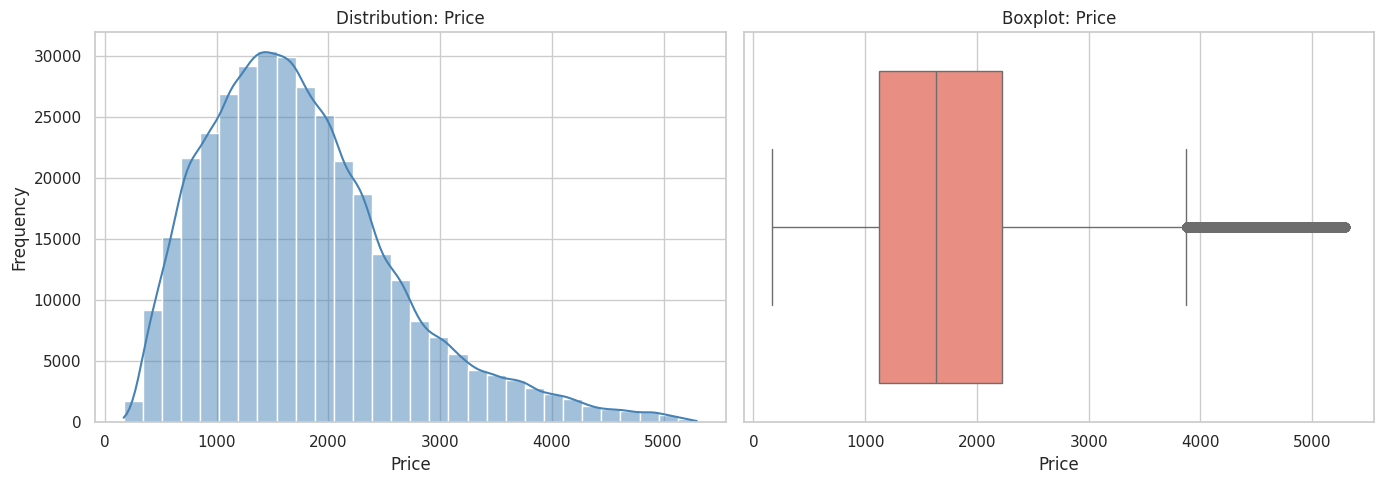

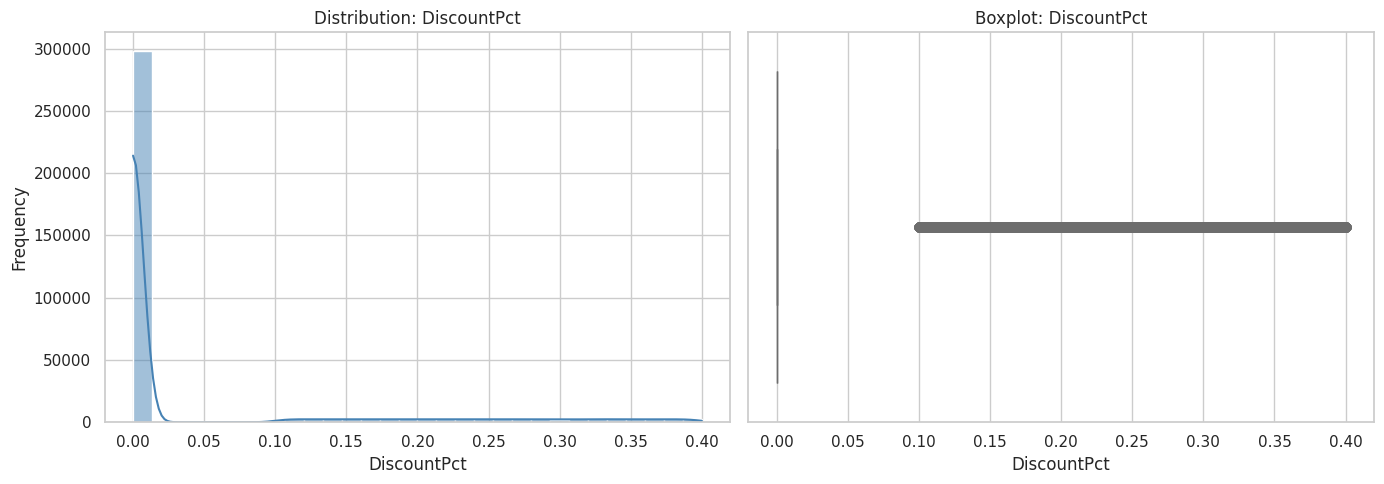

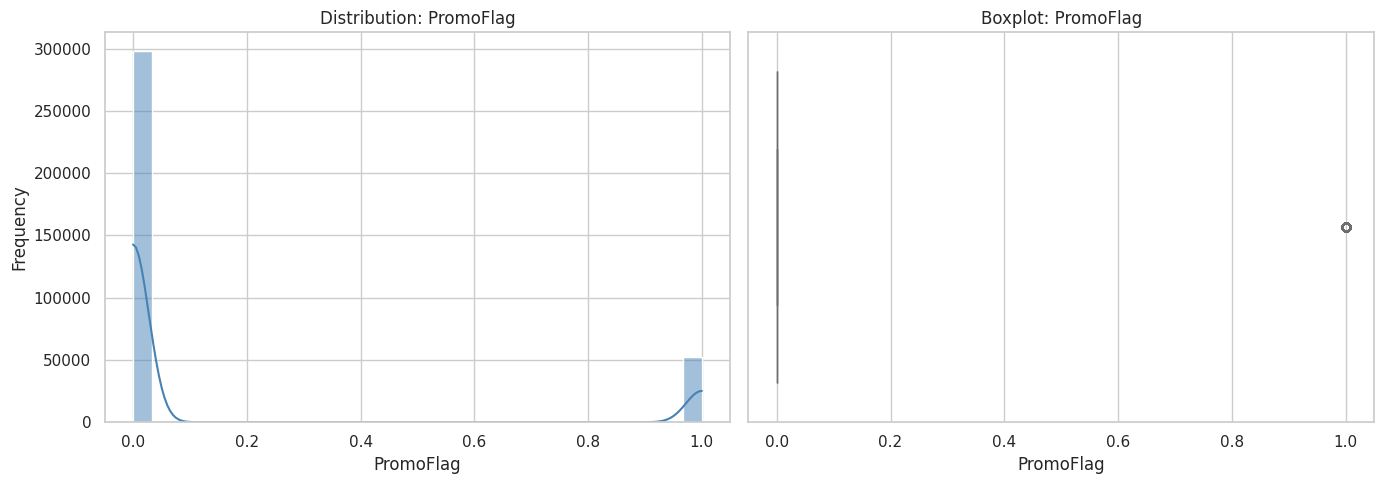

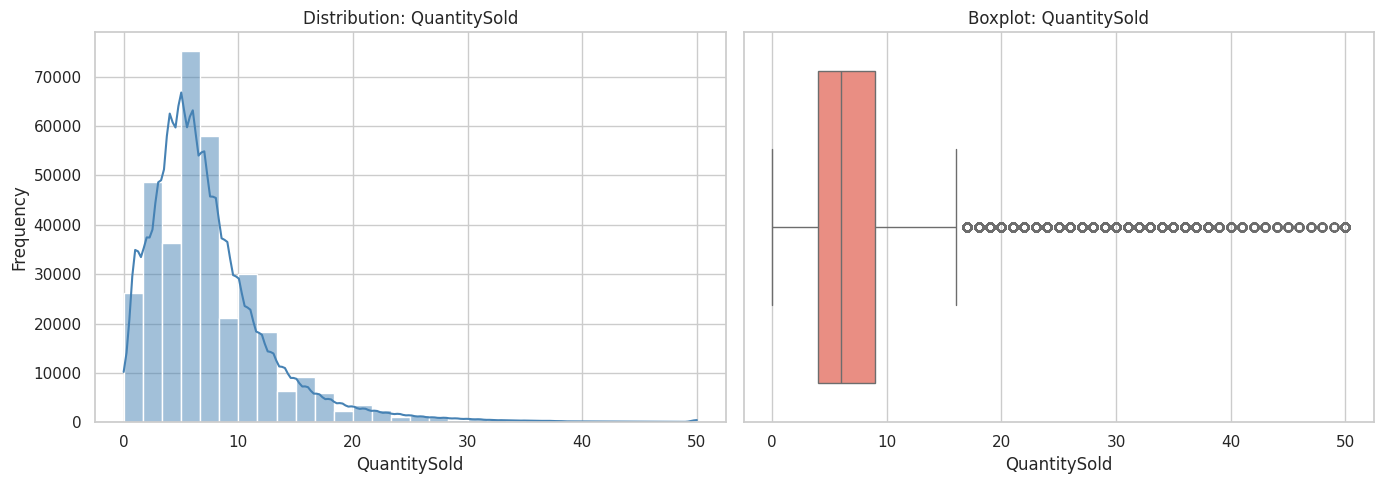

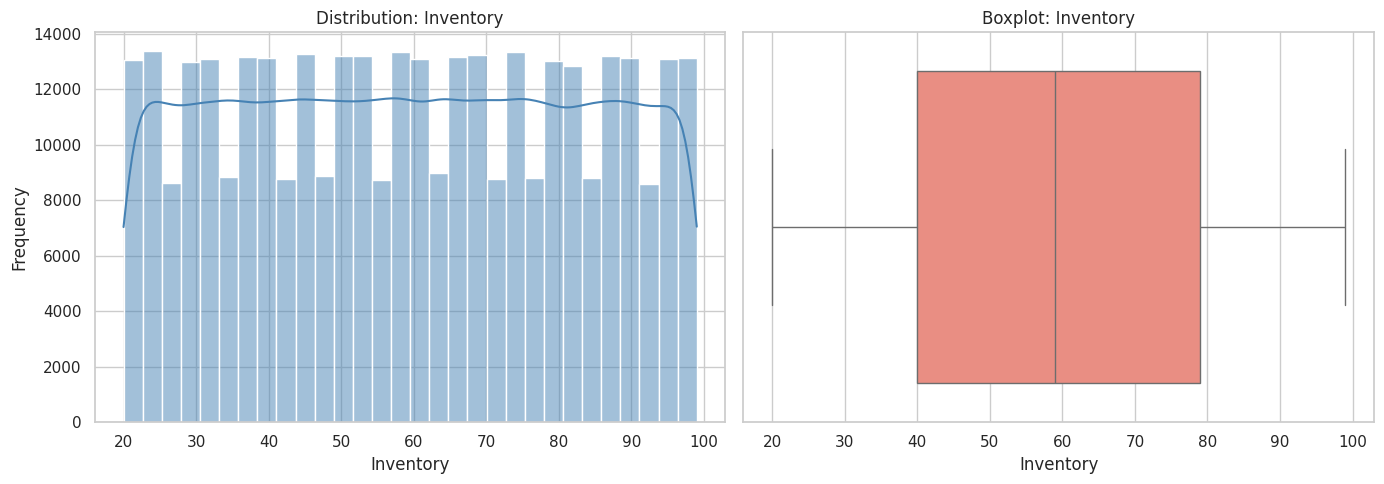

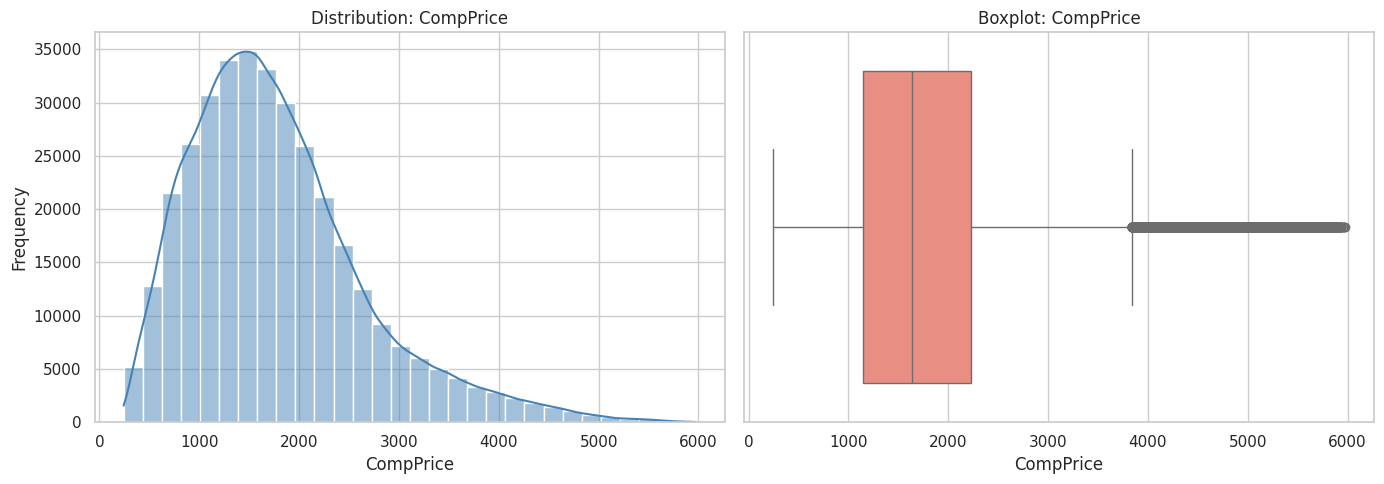

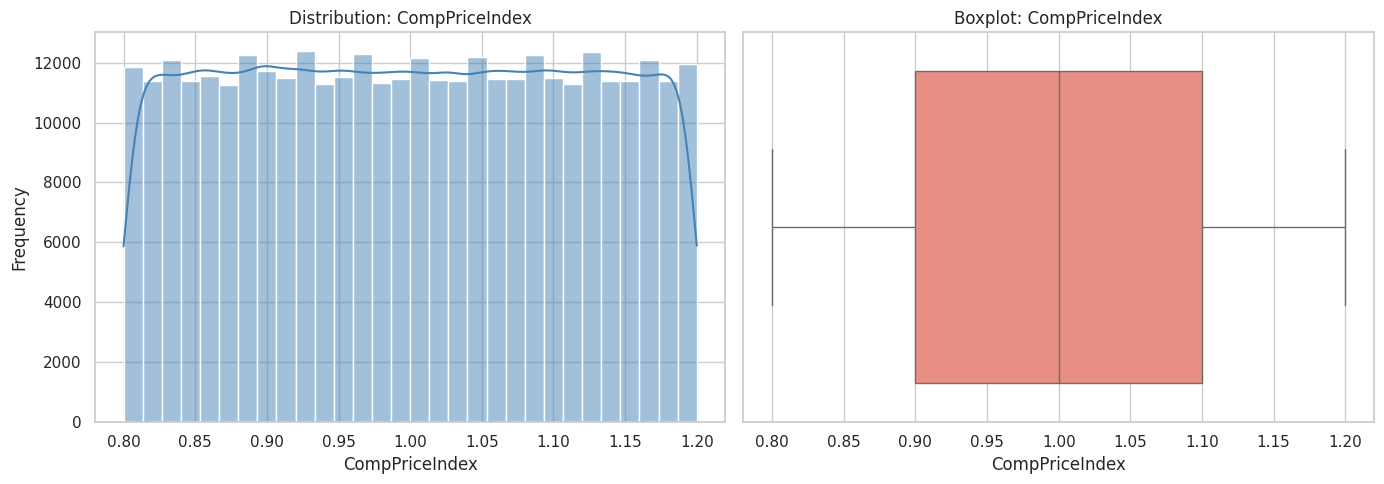

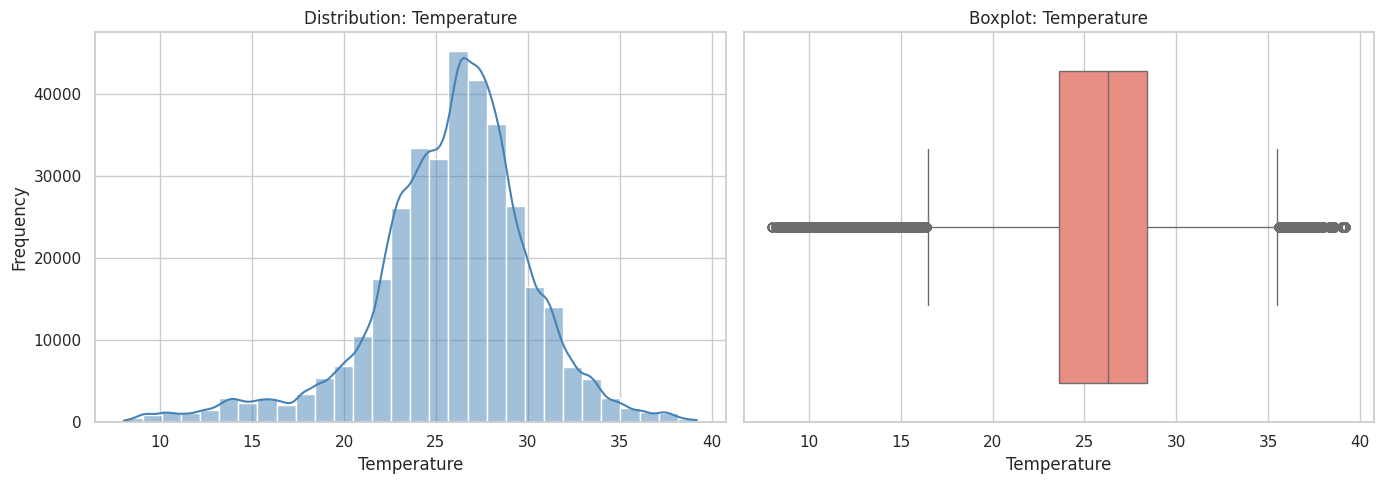

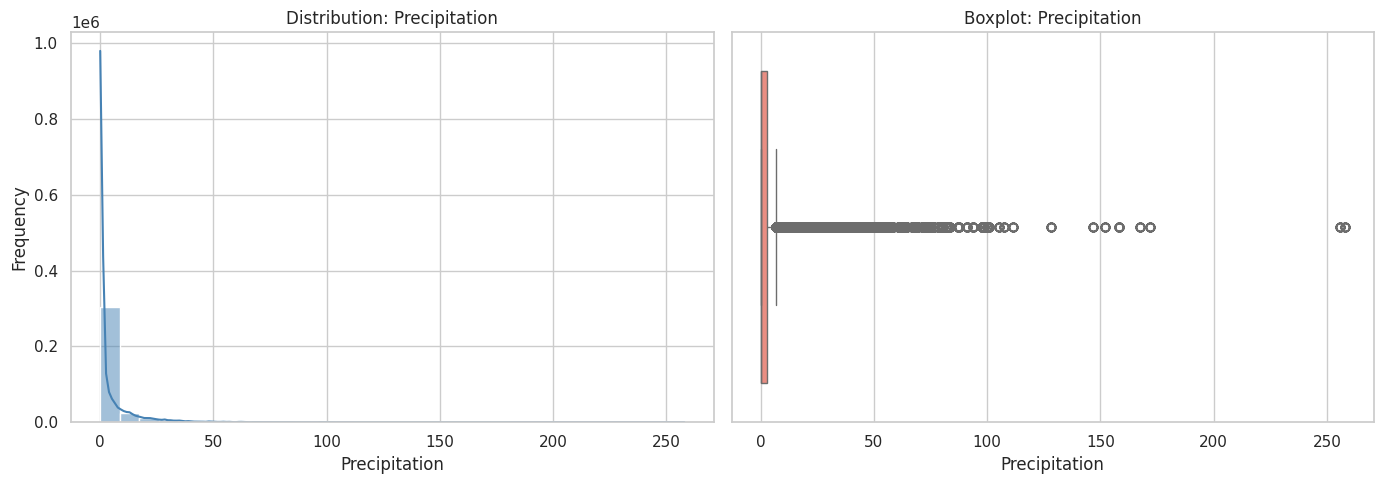

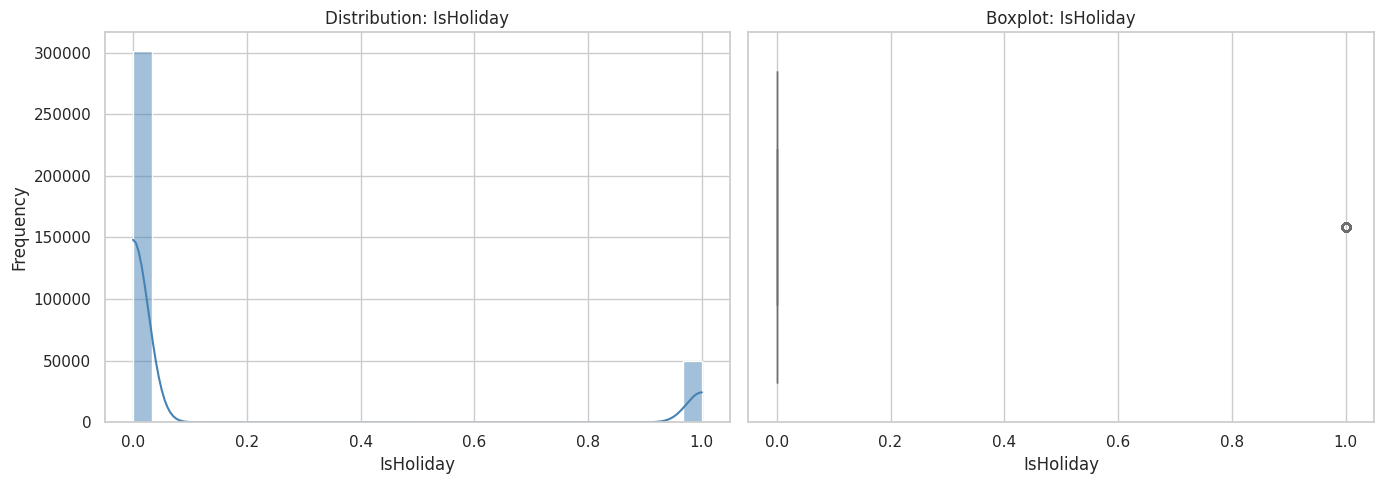

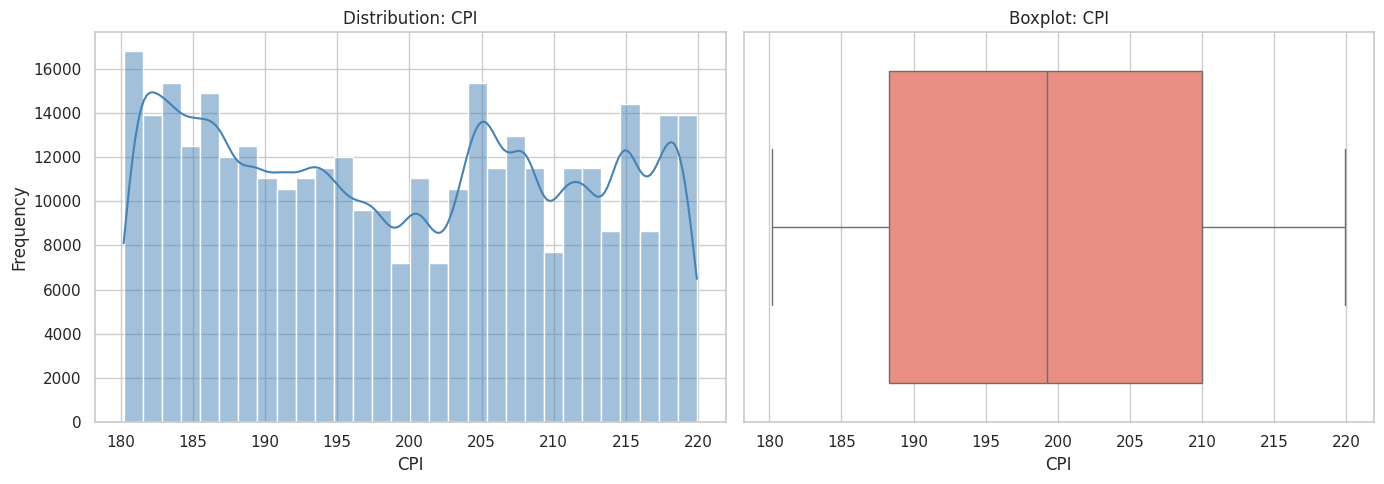

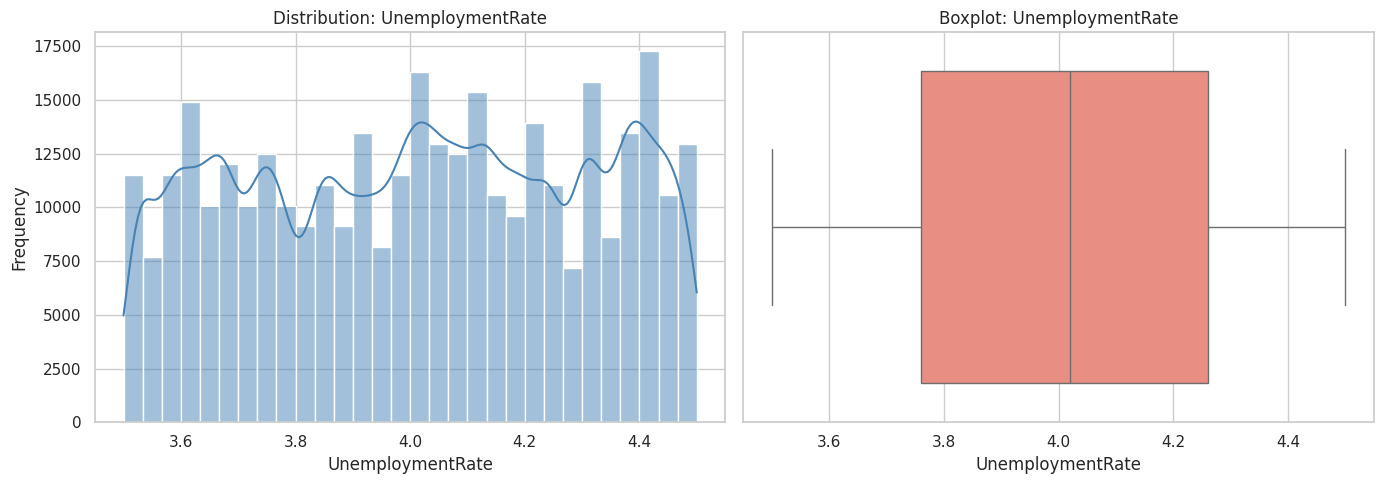

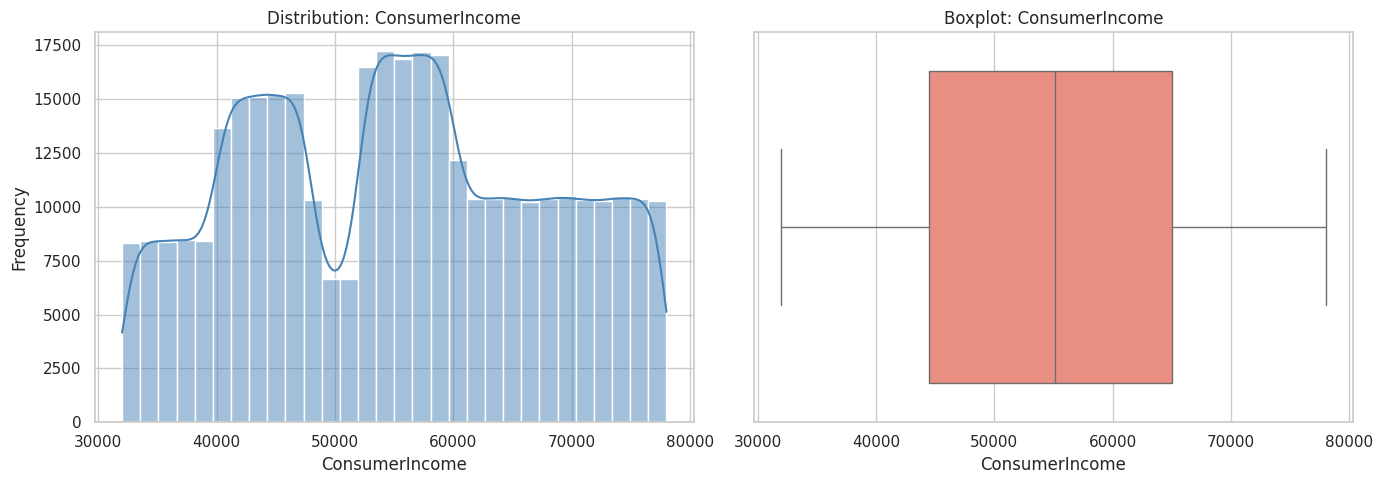

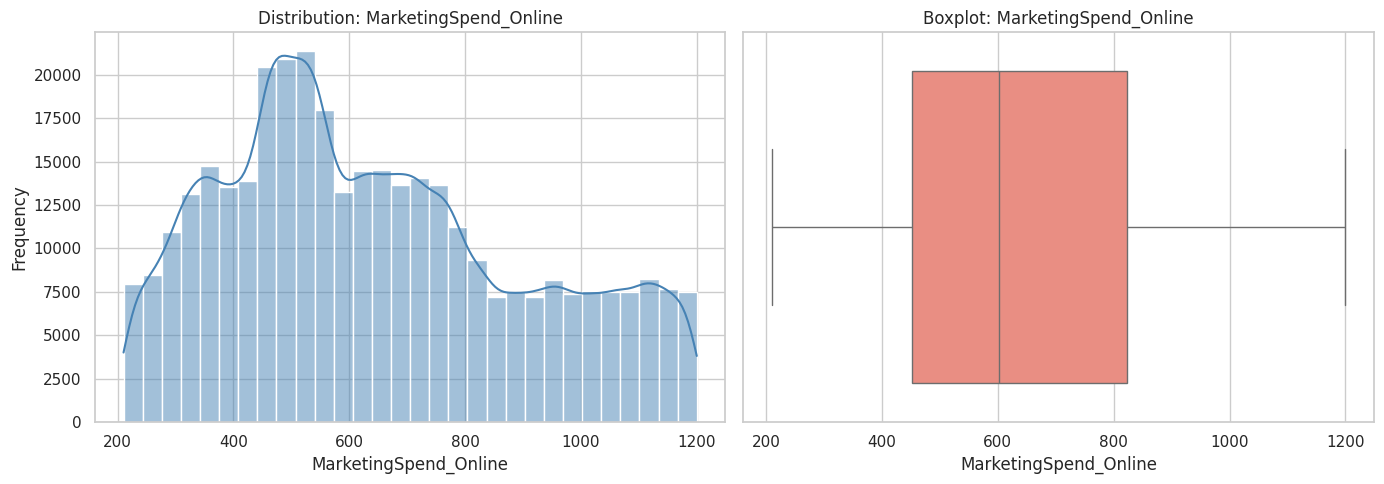

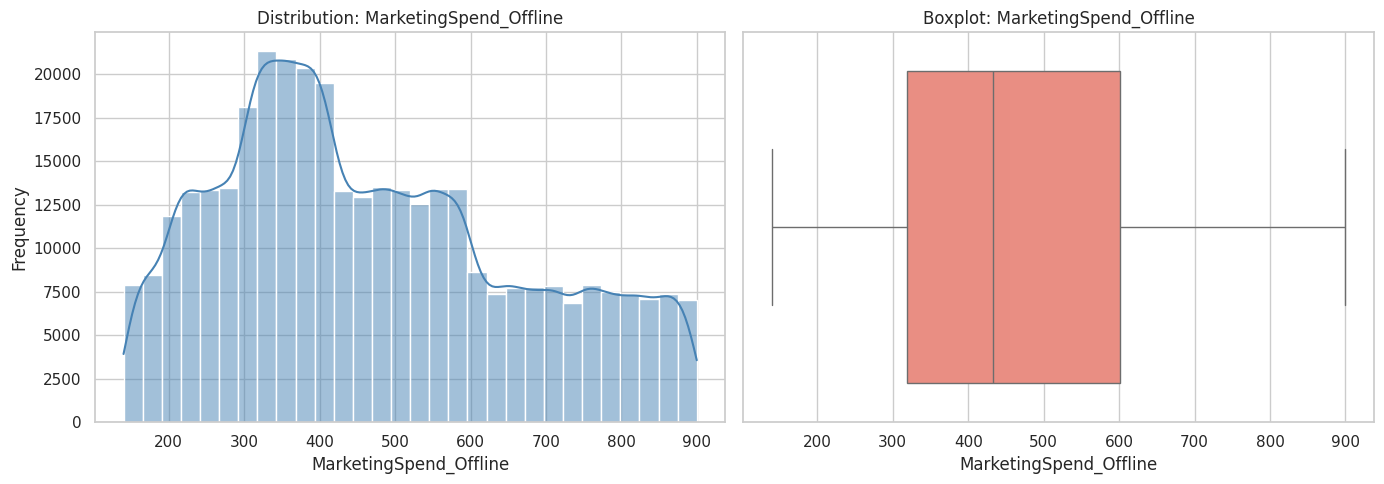

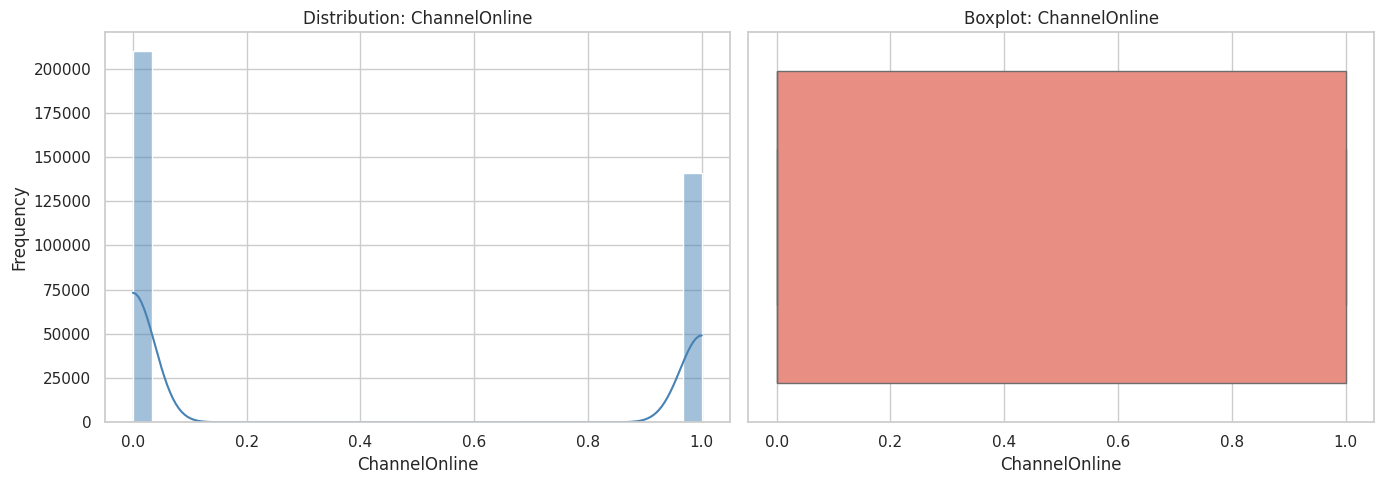

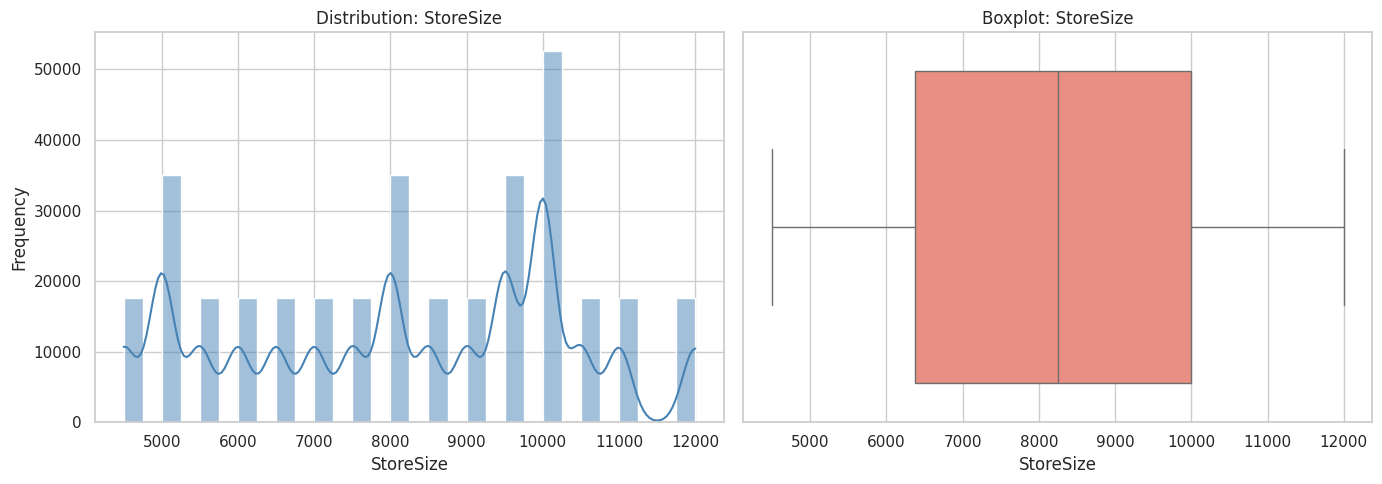

In [ ]:
# Distributions of numeric columns
numeric_cols = df_eda.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_eda[col], kde=True, bins=30, color='steelblue')
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_eda[col], color='salmon')
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

<Axes: title={'center': 'Top Brands by Units Sold'}, xlabel='Brand'>

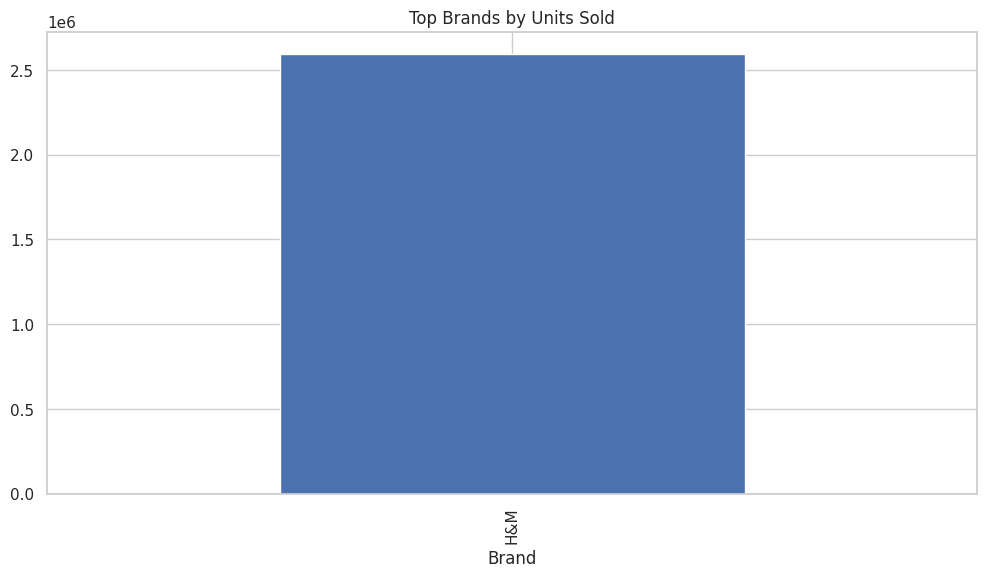

In [ ]:
# Top brands by units_sold
df_eda.groupby("Brand")["QuantitySold"].sum().sort_values(ascending=False).head(10).plot(
    kind="bar", title="Top Brands by Units Sold"
)

In [ ]:
# Price distribution by category
sns.boxplot(x="Category", y="price_unit", data=df_eda)

<Axes: title={'center': 'Sales by Region'}, xlabel='Region'>

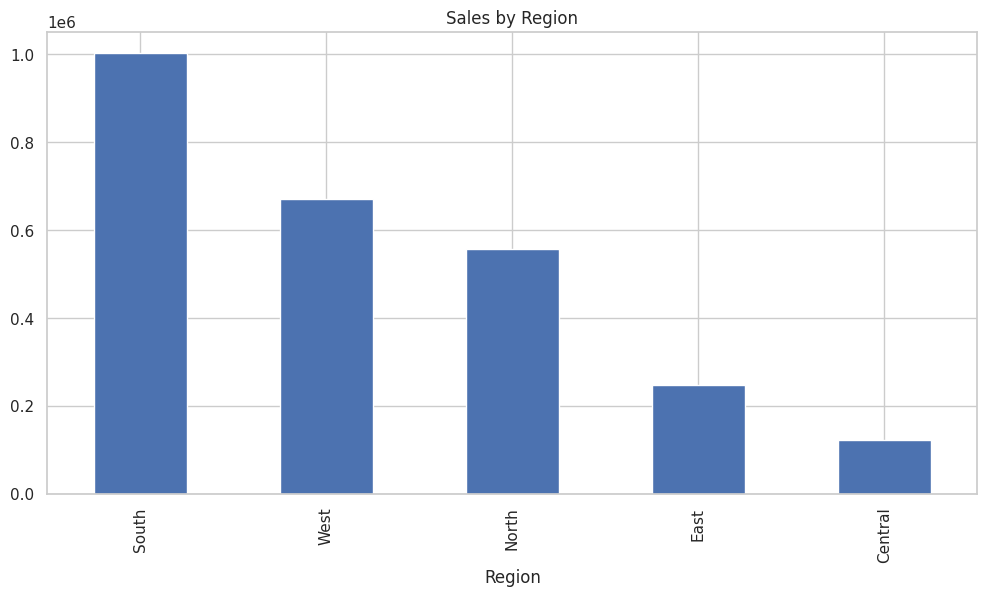

In [ ]:
# Units sold by region
df_eda.groupby("Region")["QuantitySold"].sum().sort_values(ascending=False).plot(
    kind="bar", title="Sales by Region"
)

In [ ]:
# Average sales by promo
print(df_eda.groupby("PromoFlag")["QuantitySold"].mean())

PromoFlag
0     6.353237
1    13.328235
Name: QuantitySold, dtype: float64


<Axes: xlabel='PromoFlag', ylabel='QuantitySold'>

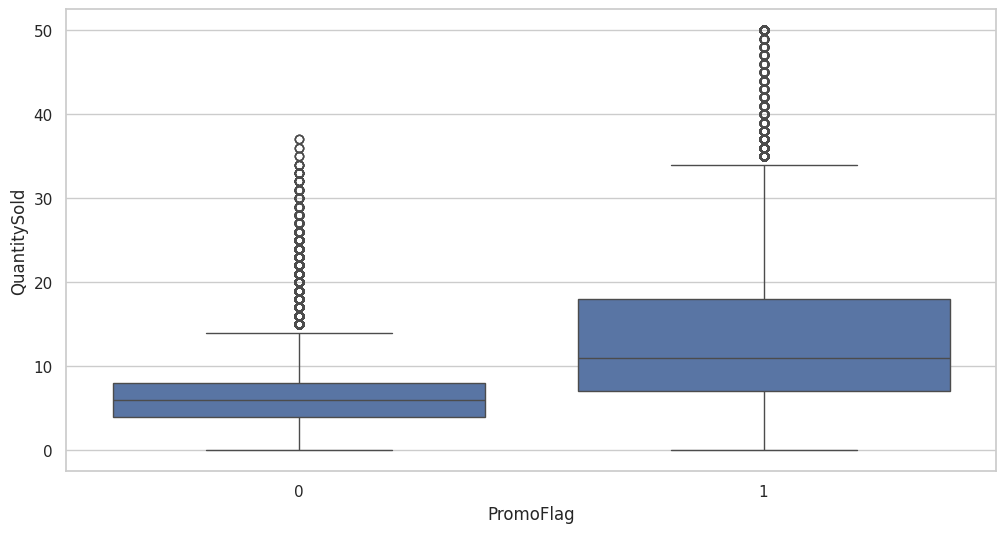

In [ ]:
# Boxplot of promo vs units_sold
sns.boxplot(x="PromoFlag", y="QuantitySold", data=df_eda)

In [ ]:
# Promo effect by channel
promo_channel = df_eda.groupby(["channel", "PromoFlag"])["QuantitySold"].mean().unstack()
promo_channel.plot(kind="bar", title="Promo Effect by Channel")

KeyError: 'channel'

# Preprocessing
To ensure data consistency, we **removed** rows containing **negative** values in key numeric features:
`units_sold`, `stock_available`, `delivered_qty`, `delivery_days`. These fields must be non-negative by definition in the retail context.

Only **3 rows** were affected and removed.

In [ ]:
# Remove rows with any negative values in those columns
df = df[(df[["QuantitySold", "stock_available", "delivered_qty", "delivery_days"]] >= 0).all(axis=1)].copy()
df = df.sort_values(["sku", "date"]).reset_index(drop=True)
initial_rows = df_eda.shape[0]
final_rows = df.shape[0]
print(f"Rows removed due to negative values: {initial_rows - final_rows}")

# Feature Engineering


**Lag Features:**  
We generate lagged values of the target variable `units_sold` (e.g., `lag_1`, `lag_7`) to capture short-term memory and autoregressive patterns.

**Momentum (Lag Ratios):**  
To detect sales acceleration/deceleration, we compute ratios between lag features (e.g., `lag_7 / lag_1`, `lag_14 / lag_3`).

**Rolling Statistics on Sales:**  
We apply 7-day rolling windows (shifted by 1 day) to extract smoothed metrics like `mean`, `std`, `max`, `min` of `units_sold`.




In [ ]:
# Lag features for target
for lag in [1, 2, 3, 7, 14, 28]:
    df[f"lag_{lag}"] = df.groupby("sku")["units_sold"].shift(lag)

# Momentum (ratios of lags)
df["momentum_7_1"] = df["lag_1"] / (df["lag_7"] + 1e-3)
df["momentum_14_7"] = df["lag_7"] / (df["lag_14"] + 1e-3)

# Rolling statistics
df["rolling_mean_7"] = df.groupby("sku")["units_sold"].transform(lambda x: x.shift(1).rolling(7).mean())
df["rolling_std_7"]  = df.groupby("sku")["units_sold"].transform(lambda x: x.shift(1).rolling(7).std())
df["rolling_max_7"]  = df.groupby("sku")["units_sold"].transform(lambda x: x.shift(1).rolling(7).max())
df["rolling_min_7"]  = df.groupby("sku")["units_sold"].transform(lambda x: x.shift(1).rolling(7).min())



**Rolling Trend (Slope):**  
We fit a linear regression on the past 7 days of sales per SKU to estimate local trend direction (sales increasing or declining).

**Lagged Explanatory Variables:**  
We also lag external variables such as:
- `price_unit`
- `promotion_flag`
- `delivery_days`
- `stock_available`  
This captures their delayed effects on demand.

In [ ]:
# Rolling trend (linear regression slope over last 7 days)
def rolling_trend(x):
    return x.shift(1).rolling(7).apply(lambda z: np.polyfit(range(len(z)), z, 1)[0] if len(z.dropna()) == 7 else np.nan)

df["trend_7"] = df.groupby("sku")["units_sold"].transform(rolling_trend)

# Lags for price, promo, delivery, stock
df["price_lag_1"] = df.groupby("sku")["price_unit"].shift(1)
df["promo_lag_1"] = df.groupby("sku")["promotion_flag"].shift(1)
df["promo_effect"] = df["promotion_flag"] * df["lag_1"]
df["delivery_lag_7"] = df.groupby("sku")["delivery_days"].shift(7)
df["stock_lag_1"] = df.groupby("sku")["stock_available"].shift(1)


KeyError: 'sku'

**SKU Global Stats:**  
Long-term aggregations (mean, min, max, std) of `units_sold` per SKU act as stable product-level anchors.

**Date Features:**  
Standard calendar-based variables:
- `dayofweek`, `month`, `year`
- `is_weekend`, `is_month_start`, `is_month_end`


In [ ]:
# SKU global statistics
sku_stats = df.groupby("sku")["units_sold"].agg(["mean", "min", "max", "std"]).reset_index()
sku_stats.columns = ["sku", "sku_mean", "sku_min", "sku_max", "sku_std"]
df = df.merge(sku_stats, on="sku", how="left")

# Date features
df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
df["is_month_end"]   = df["date"].dt.is_month_end.astype(int)
df["dayofweek"]      = df["date"].dt.dayofweek
df["month"]          = df["date"].dt.month
df["year"]           = df["date"].dt.year
df["is_weekend"]     = df["dayofweek"].isin([5, 6]).astype(int)


**Rolling Stats by Category:**  
7-day rolling `mean` and `std` of `units_sold` per `category`, capturing macro-level category trends.

**Price & Promo Rolling Effects:**  
We compute:
- Rolling mean of `price_unit`
- Rolling sum of `promotion_flag`  
These help model smoothed marketing effects.

**Calendar Positioning:**  
Features like normalized `day`, `week_of_month` capture position within the month (e.g., beginning/end spike effects).



In [ ]:
# Rolling stats per category
df["category_rolling_mean_7"] = df.groupby("category")["units_sold"].transform(lambda x: x.shift(1).rolling(7).mean())
df["category_rolling_std_7"]  = df.groupby("category")["units_sold"].transform(lambda x: x.shift(1).rolling(7).std())

# Price & promo rolling
df["price_rolling_mean_7"] = df.groupby("sku")["price_unit"].transform(lambda x: x.shift(1).rolling(7).mean())
df["promo_rolling_7"]      = df.groupby("sku")["promotion_flag"].transform(lambda x: x.shift(1).rolling(7).sum())

# Calendar position
df["day"] = df["date"].dt.day
df["week_of_month"] = df["day"] // 7 + 1


**Stockout Signals:**  
We flag stockouts:
- `is_stockout`: binary if stock was zero
- `rolling_stockouts`: sum of stockouts over past 7 days

**Time Since Last Event:**  
Custom counters for:
- Days since last **promotion**
- Days since last **delivery**  
These features capture campaign recency and supply rhythm.

**Seasonal Signals:**  
We add sine/cosine transformations of `month` and `dayofweek` to inject continuous cyclic patterns into the model.

**Interaction Terms:**  
Manually crafted interaction features like:
- `promotion_flag × dayofweek`
- `price_unit × stock_available`  
To capture compound effects.

In [ ]:
# Stockout indicators
df["stockout_flag"] = ((df["stock_available"] == 0) & (df["delivered_qty"] > 0)).astype(int)
df["rolling_stockouts_7"] = df.groupby("sku")["stockout_flag"].transform(lambda x: x.shift(1).rolling(7).sum())

# Time since last promo / delivery
def time_since_event(series):
    return series[::-1].cumsum()[::-1] * series

df["time_since_promo"] = df.groupby("sku")["promotion_flag"].transform(lambda x: time_since_event(x == 0))
df["time_since_delivery"] = df.groupby("sku")["delivery_days"].transform(lambda x: time_since_event(x == 0))

# Seasonal signals
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["dow_sin"]   = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"]   = np.cos(2 * np.pi * df["dayofweek"] / 7)

# Interaction features
df["promo_dow"] = df["promotion_flag"] * df["dayofweek"]
df["price_x_stock"] = df["price_unit"] * df["stock_available"]

**Ordinal Encoding:**  
We convert `sku`, `segment`, `category` into ordinal integers.  
Although numerically encoded, we pass them as `categorical_feature` to the model — **so LightGBM treats them as categories**, not numerical.

**Final Cleaning:**  
We drop rows with missing values caused by lag or rolling windows — ensuring no leakage and clean inputs.



In [ ]:
# Ordinal encoding
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[["sku_cat", "segment_cat", "category_cat"]] = enc.fit_transform(df[["sku", "segment", "category"]])

# Remove rows with NaN after feature generation
df = df.dropna()

# Feature set
exclude_cols = ["date", "sku", "brand", "segment", "channel", "region", "pack_type", "delivered_qty", "units_sold", "category"]
features = [col for col in df.columns if col not in exclude_cols and not np.issubdtype(df[col].dtype, np.datetime64)]

categorical_features = [
    "sku_cat", "segment_cat", "category_cat",
    "dayofweek", "month", "is_weekend",
    "promotion_flag", "is_month_start", "is_month_end"
]
target = "units_sold"


**Train/Test Split:**  
The final dataset is split **by date**:  
- **Train:** All data before cutoff  
- **Test:** Last **42 days** of data, per category  
This respects time ordering and prevents future leaks.

In [ ]:
# Split data based on time
cutoff_date = df["date"].max() - pd.Timedelta(days=42)
train = df[df["date"] <= cutoff_date].copy()
test  = df[df["date"] > cutoff_date].copy()

# Model Training Pipeline (per Category)

**1. Category-wise Modeling:**  
We train a separate model for each `category` of products to better capture product-specific patterns and avoid interference between unrelated SKUs.

**2. Safe MAPE Calculation:**  
The function `safe_mape` is used to compute MAPE only on non-zero actual values to avoid division errors.

**3. Train/Test Split per Category:**  
For each category:
- We extract the last 42 days as the test set.
- The rest is used for training.
- Skip categories with too few samples (train < 50 or test < 10).

**4. Initial Model for Feature Importance:**  
We fit a baseline LightGBM model with default parameters to get feature importances (`.feature_importances_`) and use that to rank features.

**5. Feature Selection Loop:**  
We perform a greedy forward selection:
- Try top-K features from the importance list (with step size 5).
- Train a model and compute RMSE on test.
- Save the feature set that gives the lowest RMSE.

**6. Final Model with Selected Features:**  
We then fit the final model with:
- More trees (`n_estimators=500`)
- Slower learning rate
- Column and row subsampling for regularization
- `categorical_feature` list is passed only for features included in the best subset

**7. Prediction & Storage:**  
We save predictions for the test set, clip negative values to 0, and store:
- The trained model
- The selected features per category
- The predictions

**8. Metrics Calculation (per Category):**  
We compute:
- `RMSE`: Root Mean Squared Error
- `MAPE`: Mean Absolute Percentage Error (safe)
- `SMAPE`: Symmetric MAPE
- `R2`: Coefficient of determination
- `N.features`: number of selected features used for the final model

---

## Modeling Strategy Justification

**Why model per `category`:**

- **Heterogeneous sales patterns:** Different product categories (e.g. Milk vs. SnackBar) show drastically different sales dynamics, price elasticity, seasonality, and promo response. A single model would mix incompatible patterns and reduce accuracy.
- **Feature relevance differs:** Features like `delivery_days`, `stock_available`, or even `promo_flag` may have varying importance across categories. Separate models allow for specialized feature selection per category.
- **Avoid overfitting to dominant categories:** In a unified model, dominant categories can overpower rare ones. By isolating training per category, we balance focus and reduce data bias.

**Why forecast per day (not weekly):**

- **Granular decision making:** Daily predictions are more actionable for operational planning (inventory, logistics, promos).
- **Promo and stock events are short-term:** Many key drivers like promotions and stock-outs operate on daily resolution — aggregating weekly would smooth out these effects.
- **Improved pattern recognition:** Daily modeling captures fine-grained seasonality (day-of-week effects, weekend dips/spikes, etc.) which weekly aggregation would blur.
- **Data volume allows it:** The dataset is large and detailed enough to support day-level training per category without overfitting.


In [ ]:
category_models = {}
category_preds = []
category_metrics = {}

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask])

for cat in tqdm(df["category"].unique(), desc="Training per category"):
    df_cat = df[df["category"] == cat].copy()
    cutoff = df_cat["date"].max() - pd.Timedelta(days=42)
    train_c = df_cat[df_cat["date"] <= cutoff]
    test_c  = df_cat[df_cat["date"] > cutoff]

    if len(train_c) < 30 or len(test_c) < 7:
        continue

    # Initial model for feature ranking
    base_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1)
    base_model.fit(train_c[features], train_c[target], categorical_feature=[f for f in categorical_features if f in features])
    fi = pd.Series(base_model.feature_importances_, index=features).sort_values(ascending=False)

    best_score = float("inf")
    best_features = features

    # Feature selection loop
    for k in range(10, len(features) + 1, 5):
        top_k = fi.head(k).index.tolist()
        cat_features_k = [f for f in categorical_features if f in top_k]
        model_k = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1) # Create new instance
        model_k.fit(train_c[top_k], train_c[target], categorical_feature=cat_features_k)


        preds_k = np.clip(model_k.predict(test_c[top_k]), 0, None)
        rmse_k = mean_squared_error(test_c[target], preds_k)
        if np.sqrt(rmse_k) < best_score:
            best_score = np.sqrt(rmse_k)
            best_features = top_k

    # Final model on selected features
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    model.fit(
        train_c[best_features], train_c[target],
        categorical_feature=[f for f in categorical_features if f in best_features]
    )

    test_c = test_c.copy()
    test_c["prediction"] = np.clip(model.predict(test_c[best_features]), 0, None)
    category_preds.append(test_c)

    category_models[cat] = {"model": model, "features": best_features}

    # Metrics
    rmse = mean_squared_error(test_c[target], test_c["prediction"])
    mape = safe_mape(test_c[target], test_c["prediction"])
    smape = np.mean(2 * np.abs(test_c[target] - test_c["prediction"]) /
                    (np.abs(test_c[target]) + np.abs(test_c["prediction"]) + 1e-8))
    r2 = r2_score(test_c[target], test_c["prediction"])

    category_metrics[cat] = {
        "RMSE": np.sqrt(rmse),
        "MAPE": mape,
        "SMAPE": smape,
        "R2": r2,
        "N_features": len(best_features)
    }

KeyError: 'category'

# Results & Interpretation


## Category-Level Evaluation

We evaluated model performance per **category** using several metrics:  
- **MAPE** (Mean Absolute Percentage Error) — focuses on relative error, sensitive to small true values.  
- **SMAPE** — more stable and symmetric.  
- **R²** — goodness-of-fit.  
- **Number of selected features** — indicates model complexity and feature relevance per category.

### Key insights:
- **ReadyMeal** showed the best performance (lowest MAPE ~18.9%, highest R² ~0.79), likely due to high, stable demand and well-captured promotional patterns.
- **Yogurt** also performed well with a large number of features selected (40), possibly due to more complex seasonality or interactions.
- **Juice** had the weakest performance (MAPE ~22.3%, R² ~0.65), likely due to higher demand volatility, more outliers, or insufficient features to capture promo dynamics.
- The number of features selected varies significantly by category, confirming the need for **custom feature selection per category**.
---

## Overall Takeaways

- The **per-category modeling strategy** shows strong potential: it allows tailoring features and models to each category's behavior.
- **Daily granularity** in modeling enables the model to pick up fine-grained changes (e.g. promotions, delivery gaps), which would be blurred in weekly aggregation.
- The pipeline provides **granular interpretability** (what worked where and why), allowing real-world deployment with category-specific adjustments and monitoring.
- Next steps may include:
  - Error analysis per channel/region
  - SHAP value analysis
  - Ensemble or meta-modeling across categories


In [ ]:
# === Aggregate all predictions ===
df_all = pd.concat(category_preds, axis=0)

# === Metrics per category ===
metrics_by_category = pd.DataFrame(category_metrics).T.reset_index().rename(columns={"index": "category"})
metrics_by_category = metrics_by_category[["category", "R2", "SMAPE", "MAPE", "N_features"]]
metrics_by_category = metrics_by_category.sort_values("MAPE")  # ← sort by MAPE (ascending)
metrics_by_category


## SKU-Level Evaluation

We further analyzed performance **at the SKU level**, calculating metrics for each individual product.

### Observations:
- **Top SKUs (MAPE ~0.17–0.19)**: These SKUs tend to have:
  - Regular, stable sales patterns
  - Sufficient historical data
  - Strong signal from promotions or price
- **Worst SKUs (MAPE > 0.25)**:
  - Sparse or noisy data
  - Possibly irregular delivery or inconsistent availability
  - Some outliers or low-sale products where relative error explodes (as MAPE is sensitive to small denominators)

This highlights that **per-SKU metrics** are critical for uncovering hidden weak spots in the model and guiding targeted improvements (e.g. synthetic data augmentation, outlier treatment, or pricing elasticity modeling).



In [ ]:
# === Metrics per SKU ===
def compute_metrics(group):
    y_true = group[target]
    y_pred = group["prediction"]
    mask = y_true != 0
    return pd.Series({
        "R2": r2_score(y_true, y_pred),
        "SMAPE": np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)),
        "MAPE": mean_absolute_percentage_error(y_true[mask], y_pred[mask]),
    })

metrics_by_sku = df_all.groupby("sku").apply(compute_metrics).reset_index()
print("\nBest SKUs by MAPE:")
metrics_by_sku.sort_values("MAPE", ascending=True).head(10).round(3)

In [ ]:
print("\n Worst SKUs by MAPE:")
metrics_by_sku.sort_values("MAPE", ascending=False).head(10).round(3)



## Weekly Trend Plots: Actual vs Predicted (per Category)

To validate temporal dynamics, we visualized the **weekly aggregation** of actual vs predicted sales.

### Conclusions from visual inspection:
- Overall, the **model tracks sales trends well** across all categories.
- Sharp drops and rises (e.g. season-end in December) are well captured, especially for **Milk**, **ReadyMeal**, and **SnackBar**.
- Slight under/over-shooting exists on some weeks, suggesting potential for adding external features (e.g. holiday flags, macro indicators).




In [ ]:
df_all["week"] = df_all["date"] - pd.to_timedelta(df_all["date"].dt.dayofweek, unit="d")
agg = df_all.groupby(["category", "week"])[["units_sold", "prediction"]].sum().reset_index()

for cat in agg["category"].unique():
    df_cat = agg[agg["category"] == cat]
    plt.figure(figsize=(10, 4))
    plt.plot(df_cat["week"], df_cat["units_sold"], label="Actual", marker="o")
    plt.plot(df_cat["week"], df_cat["prediction"], label="Predicted", marker="x")
    plt.title(f"{cat} – Weekly Prediction vs Actual")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## SHAP-Based Feature Importance for `ReadyMeal`

To better understand how our model makes predictions, we use **SHAP (SHapley Additive exPlanations)** on the trained LightGBM model for the `ReadyMeal` category.

### Key Insights:

- **stock_available** is the most influential feature. A **lower stock** strongly suppresses predicted demand, as expected.
- **time_since_promo** also plays a key role — the longer since the last promotion, the lower the predicted sales.
- **month** captures seasonal effects — certain months drive sales up or down.
- **price_x_stock** and **price_unit** show the negative effect of price: higher prices generally decrease demand.
- **promotion_flag** has a positive impact, confirming that active promotions boost sales.

### Plots:

- **Top:** Mean absolute SHAP values — shows global feature importance.
- **Bottom:** Beeswarm plot — shows distribution of SHAP values per feature and how feature value (red = high, blue = low) affects prediction.


In [ ]:
# Pick a model from one category (e.g. ReadyMeal)
model = category_models["ReadyMeal"]["model"]
used_features = category_models["ReadyMeal"]["features"]
X_sample = df[df["category"] == "ReadyMeal"][used_features].sample(500, random_state=42)

# SHAP init + explain
explainer = shap.Explainer(model)
shap_values = explainer(X_sample)

# Summary plot (global importance)
shap.plots.bar(shap_values)

# Distribution plot
shap.plots.beeswarm(shap_values)